In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
import model_selection_funcs_and_preprocessing as msf
sns.set()

In [2]:
df = pd.read_pickle('clean_data.pkl')
%pylab inline
%config InlineBackend.figure_formats = ['retina']
pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [3]:
df, logs = msf.clean_transform_df(df, test_cols=False)

In [4]:
corr_matrix = df.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False)
                 .reset_index())

#first element of sol series is the pair with the biggest correlation

In [5]:
mask1 = (sol['level_0'] == 'med_income_after_10')
mask2 = (sol['level_1'] == 'med_income_after_10')
sol[mask1]

,level_0,level_1,0
9,med_income_after_10,perc_as,0.538453
14,med_income_after_10,mult_tuition,0.450017
24,med_income_after_10,perc_over_25,0.373579
41,med_income_after_10,min_serv_inst_Historically Black,0.319681
43,med_income_after_10,perc_la,0.312072
52,med_income_after_10,perc_fem,0.258559
53,med_income_after_10,perc_alien,0.252401
68,med_income_after_10,setting_Town,0.205702
85,med_income_after_10,perc_two_or_more,0.176331
94,med_income_after_10,min_serv_inst_Not Applicable,0.162996


In [6]:
sol[mask2]

,level_0,level_1,0
3,med_ACT,med_income_after_10,0.626016
11,endowment,med_income_after_10,0.530897
32,perc_aid,med_income_after_10,0.335422
47,perc_disab,med_income_after_10,0.280085
77,perc_admit,med_income_after_10,0.189375
122,student_fac_ratio,med_income_after_10,0.132059


In [7]:
sol

,level_0,level_1,0
0,mult_tuition,sector_Public,0.802720
1,relig_Yes,sector_Public,0.696153
2,endowment,med_ACT,0.668103
3,med_ACT,med_income_after_10,0.626016
4,student_fac_ratio,sector_Public,0.611742
...,...,...,...
248,endowment,sector_Public,0.005274
249,setting_Town,min_serv_inst_Historically Black,0.004310
250,setting_Rural,min_serv_inst_Historically Black,0.003654
251,perc_nat_am,perc_alien,0.001729


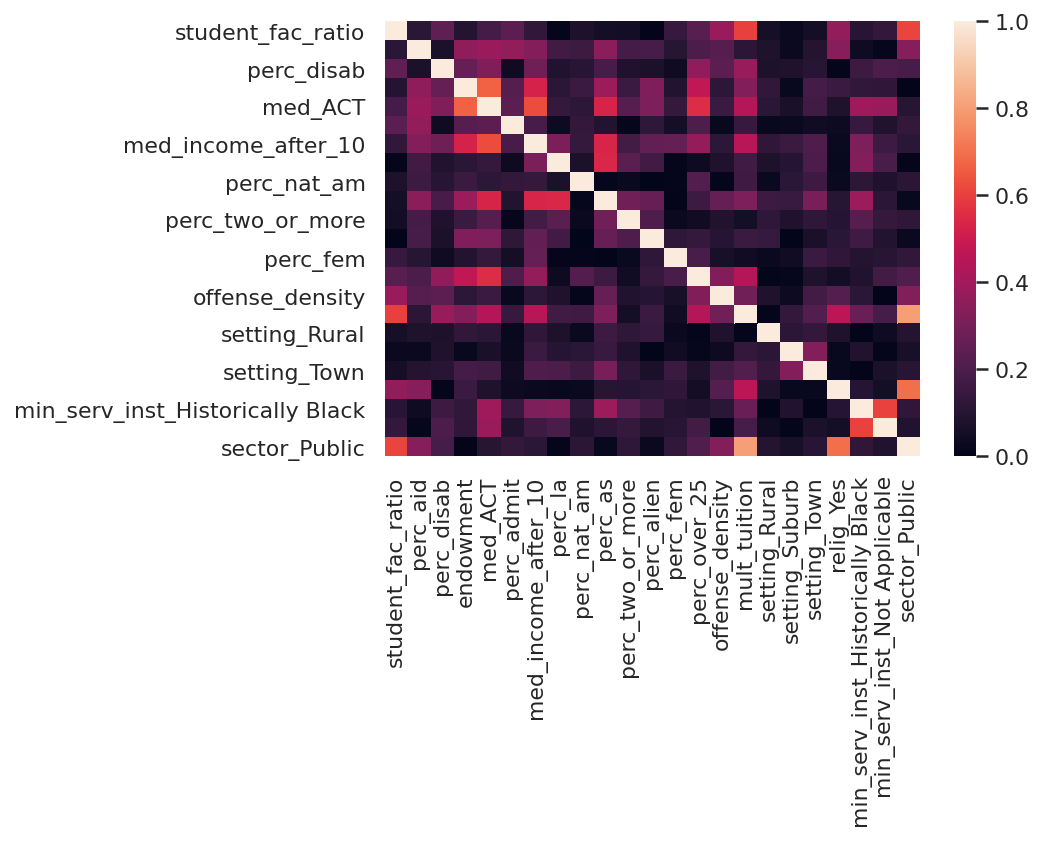

In [8]:
corrs =abs(df.corr())
sns.heatmap(abs(corrs), vmin=0, vmax=1)

In [9]:
X, X_test, y, y_test = msf.get_train_test_sets(df)

In [10]:
X.shape

(748, 22)

In [11]:
lasso_r2, lasso_alpha = msf.get_max_r2_lasso(X, y)
ridge_r2, ridge_alpha = msf.get_max_r2_ridge(X, y)

In [12]:
print(lasso_r2, ridge_r2)
print(lasso_alpha, ridge_alpha)

0.5518123014596823 0.5723361613005494
0.003003003003003003 0.7797797797797797


In [13]:
model = make_pipeline(StandardScaler(), Lasso(lasso_alpha))
model.fit(X, y)
print(model.score(X_test, y_test), model.score(X, y))

0.6226999446545713 0.5662379663700423


In [14]:
for coef, feature in sorted(zip(model['lasso'].coef_, X.columns)):
    print(feature, coef)

perc_fem -0.04249286850169711
perc_aid -0.026075206254324138
offense_density -0.015213185727193088
setting_Rural -0.005924480634027267
perc_nat_am -0.0030503088736858067
min_serv_inst_Not Applicable -0.0006719991363473932
perc_alien -0.0002626476201322806
min_serv_inst_Historically Black -0.0
perc_admit -0.0
perc_over_25 -0.0
perc_two_or_more -0.0
setting_Town -0.0
student_fac_ratio 0.002780390135220088
relig_Yes 0.0028485601073575642
perc_disab 0.00792900106136651
setting_Suburb 0.01189899072521963
perc_as 0.018888942548948764
sector_Public 0.019390231950848234
perc_la 0.023009478200037122
endowment 0.023944042969773385
med_ACT 0.04340157839729265
mult_tuition 0.0739984041241484


In [15]:
#I'm going to drop the columns that lasso zeroed out then run ridge again
drop_cols = ['perc_admit', 'perc_over_25', 'relig_Yes', 'setting_Town', 'student_fac_ratio']
df.drop(drop_cols, inplace=True, axis=1, errors='ignore')

In [16]:
X, X_test, y, y_test = msf.get_train_test_sets(df)
ridge_r2, ridge_alpha = msf.get_max_r2_ridge(X, y)

In [17]:
print(ridge_r2, ridge_alpha)

0.5737344905870805 0.6446446446446447


In [18]:
model = make_pipeline(StandardScaler(), Ridge(ridge_alpha))
model.fit(X, y)
print(model.score(X_test, y_test), model.score(X, y))

0.6192971508206004 0.5747426779790534


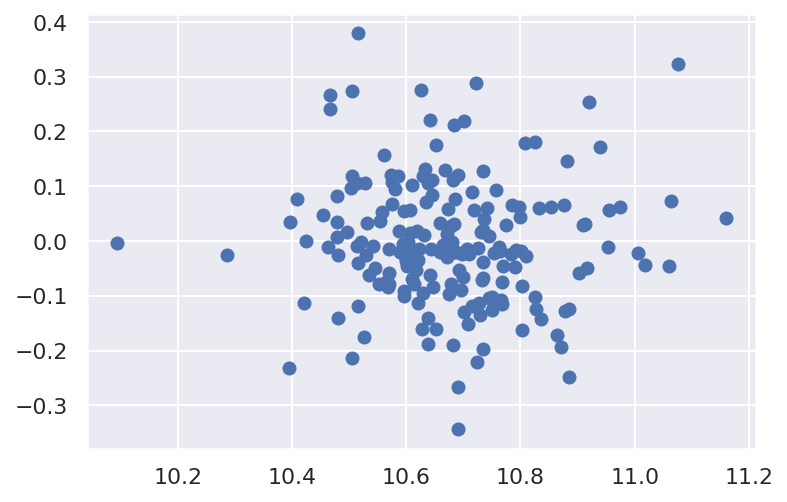

In [19]:
y_pred = model.predict(X_test)
resids = y_test - y_pred
plt.scatter(x=y_pred, y=resids)

In [20]:
logs

['student_fac_ratio',
 'perc_aid',
 'perc_disab',
 'endowment',
 'med_ACT',
 'perc_admit',
 'med_income_after_10',
 'perc_la',
 'perc_nat_am',
 'perc_as',
 'perc_two_or_more',
 'perc_alien',
 'perc_over_25',
 'offense_density',
 'mult_tuition']

Text(0.5, 1.0, 'Normal Q-Q plot')

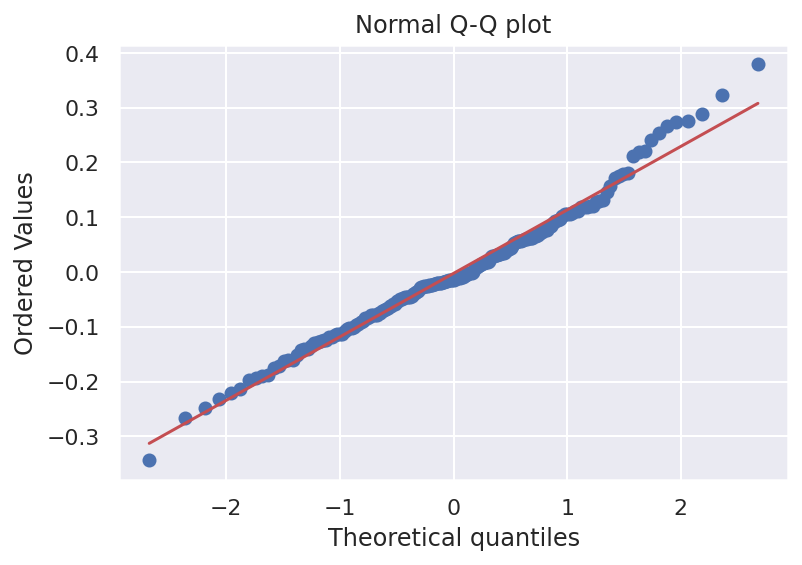

In [21]:
stats.probplot(resids, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [22]:
skews = X.skew(axis=0)

In [23]:
print(skews.sort_values(ascending=False))

setting_Rural                       4.230851
min_serv_inst_Historically Black    4.037306
setting_Suburb                      1.447615
sector_Public                       0.520389
perc_disab                          0.519139
offense_density                     0.488625
perc_fem                            0.367505
endowment                           0.112845
med_ACT                             0.092776
mult_tuition                       -0.308164
perc_nat_am                        -0.450857
perc_la                            -0.713746
perc_as                            -0.734895
perc_alien                         -1.813169
min_serv_inst_Not Applicable       -2.226833
perc_aid                           -2.794698
perc_two_or_more                   -2.827126
dtype: float64


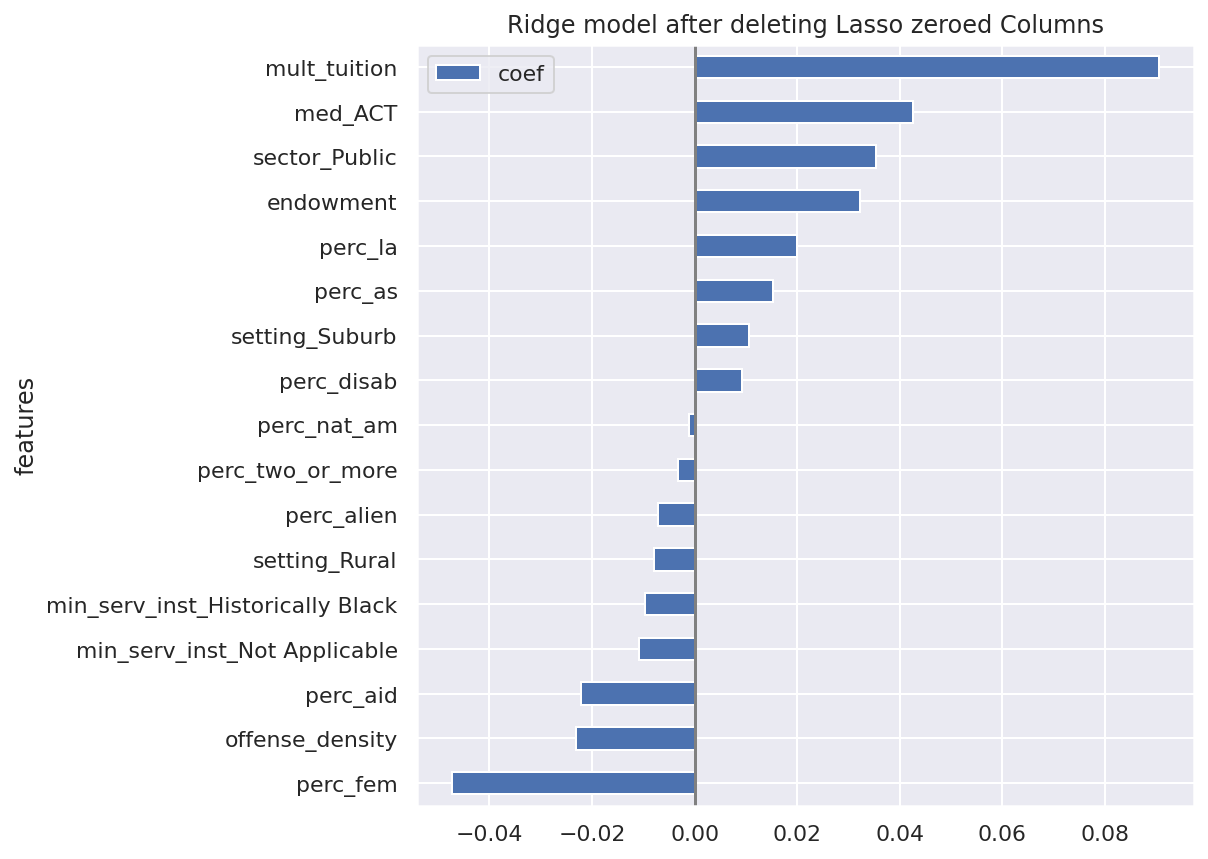

In [24]:
coefs = []
for coef, feature in sorted(zip(model['ridge'].coef_, X.columns)):
    coefs.append([feature, coef])
coefs = pd.DataFrame(coefs, columns= ['features', 'coef'])
coefs = coefs.set_index('features')
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model after deleting Lasso zeroed Columns')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [25]:
#Here is my baseline model:
lr = LinearRegression()
msf.run_lm_cv(X, y, lr)


0.5460974611209781

In [26]:
lr.fit(X, y)
lr.score(X_test, y_test)

0.619298052829676

In [27]:
lr.score(X, y)

0.5747439678394404

In [28]:
from sklearn.metrics import mean_squared_error

In [41]:
ypred = np.exp(lr.predict(X_test)) - .01
np.sqrt(mean_squared_error(np.exp(y_test) - .01, ypred))

5342.148023314946

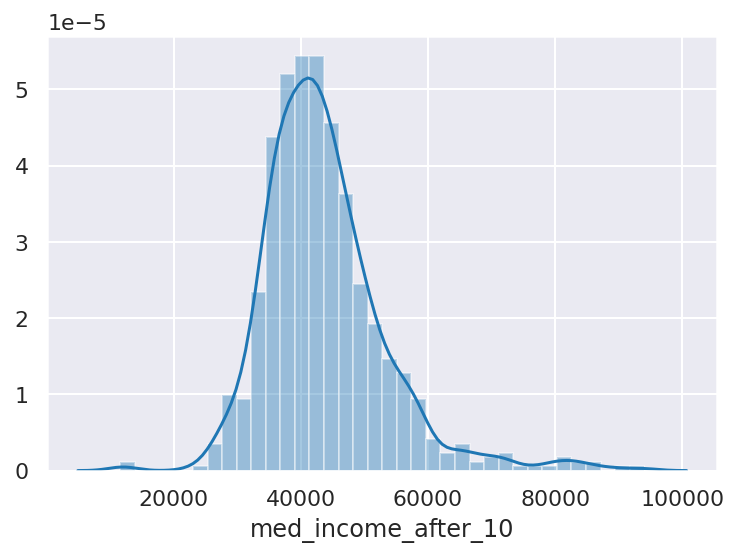

In [40]:
sns.distplot(np.exp(y)-.01)

In [ ]:
sns.scatterplot(x=(np.exp(df)-.01))

In [42]:
logs

['student_fac_ratio',
 'perc_aid',
 'perc_disab',
 'endowment',
 'med_ACT',
 'perc_admit',
 'med_income_after_10',
 'perc_la',
 'perc_nat_am',
 'perc_as',
 'perc_two_or_more',
 'perc_alien',
 'perc_over_25',
 'offense_density',
 'mult_tuition']

In [31]:
coefs.sort_values(by='coef', ascending=False)

,coef
features,
mult_tuition,0.090575
med_ACT,0.042591
sector_Public,0.035358
endowment,0.032362
perc_la,0.019966
perc_as,0.015385
setting_Suburb,0.010588
perc_disab,0.009190
perc_nat_am,-0.001077


In [78]:
from sklearn.linear_model import lars_path
## Scale the variables
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso')

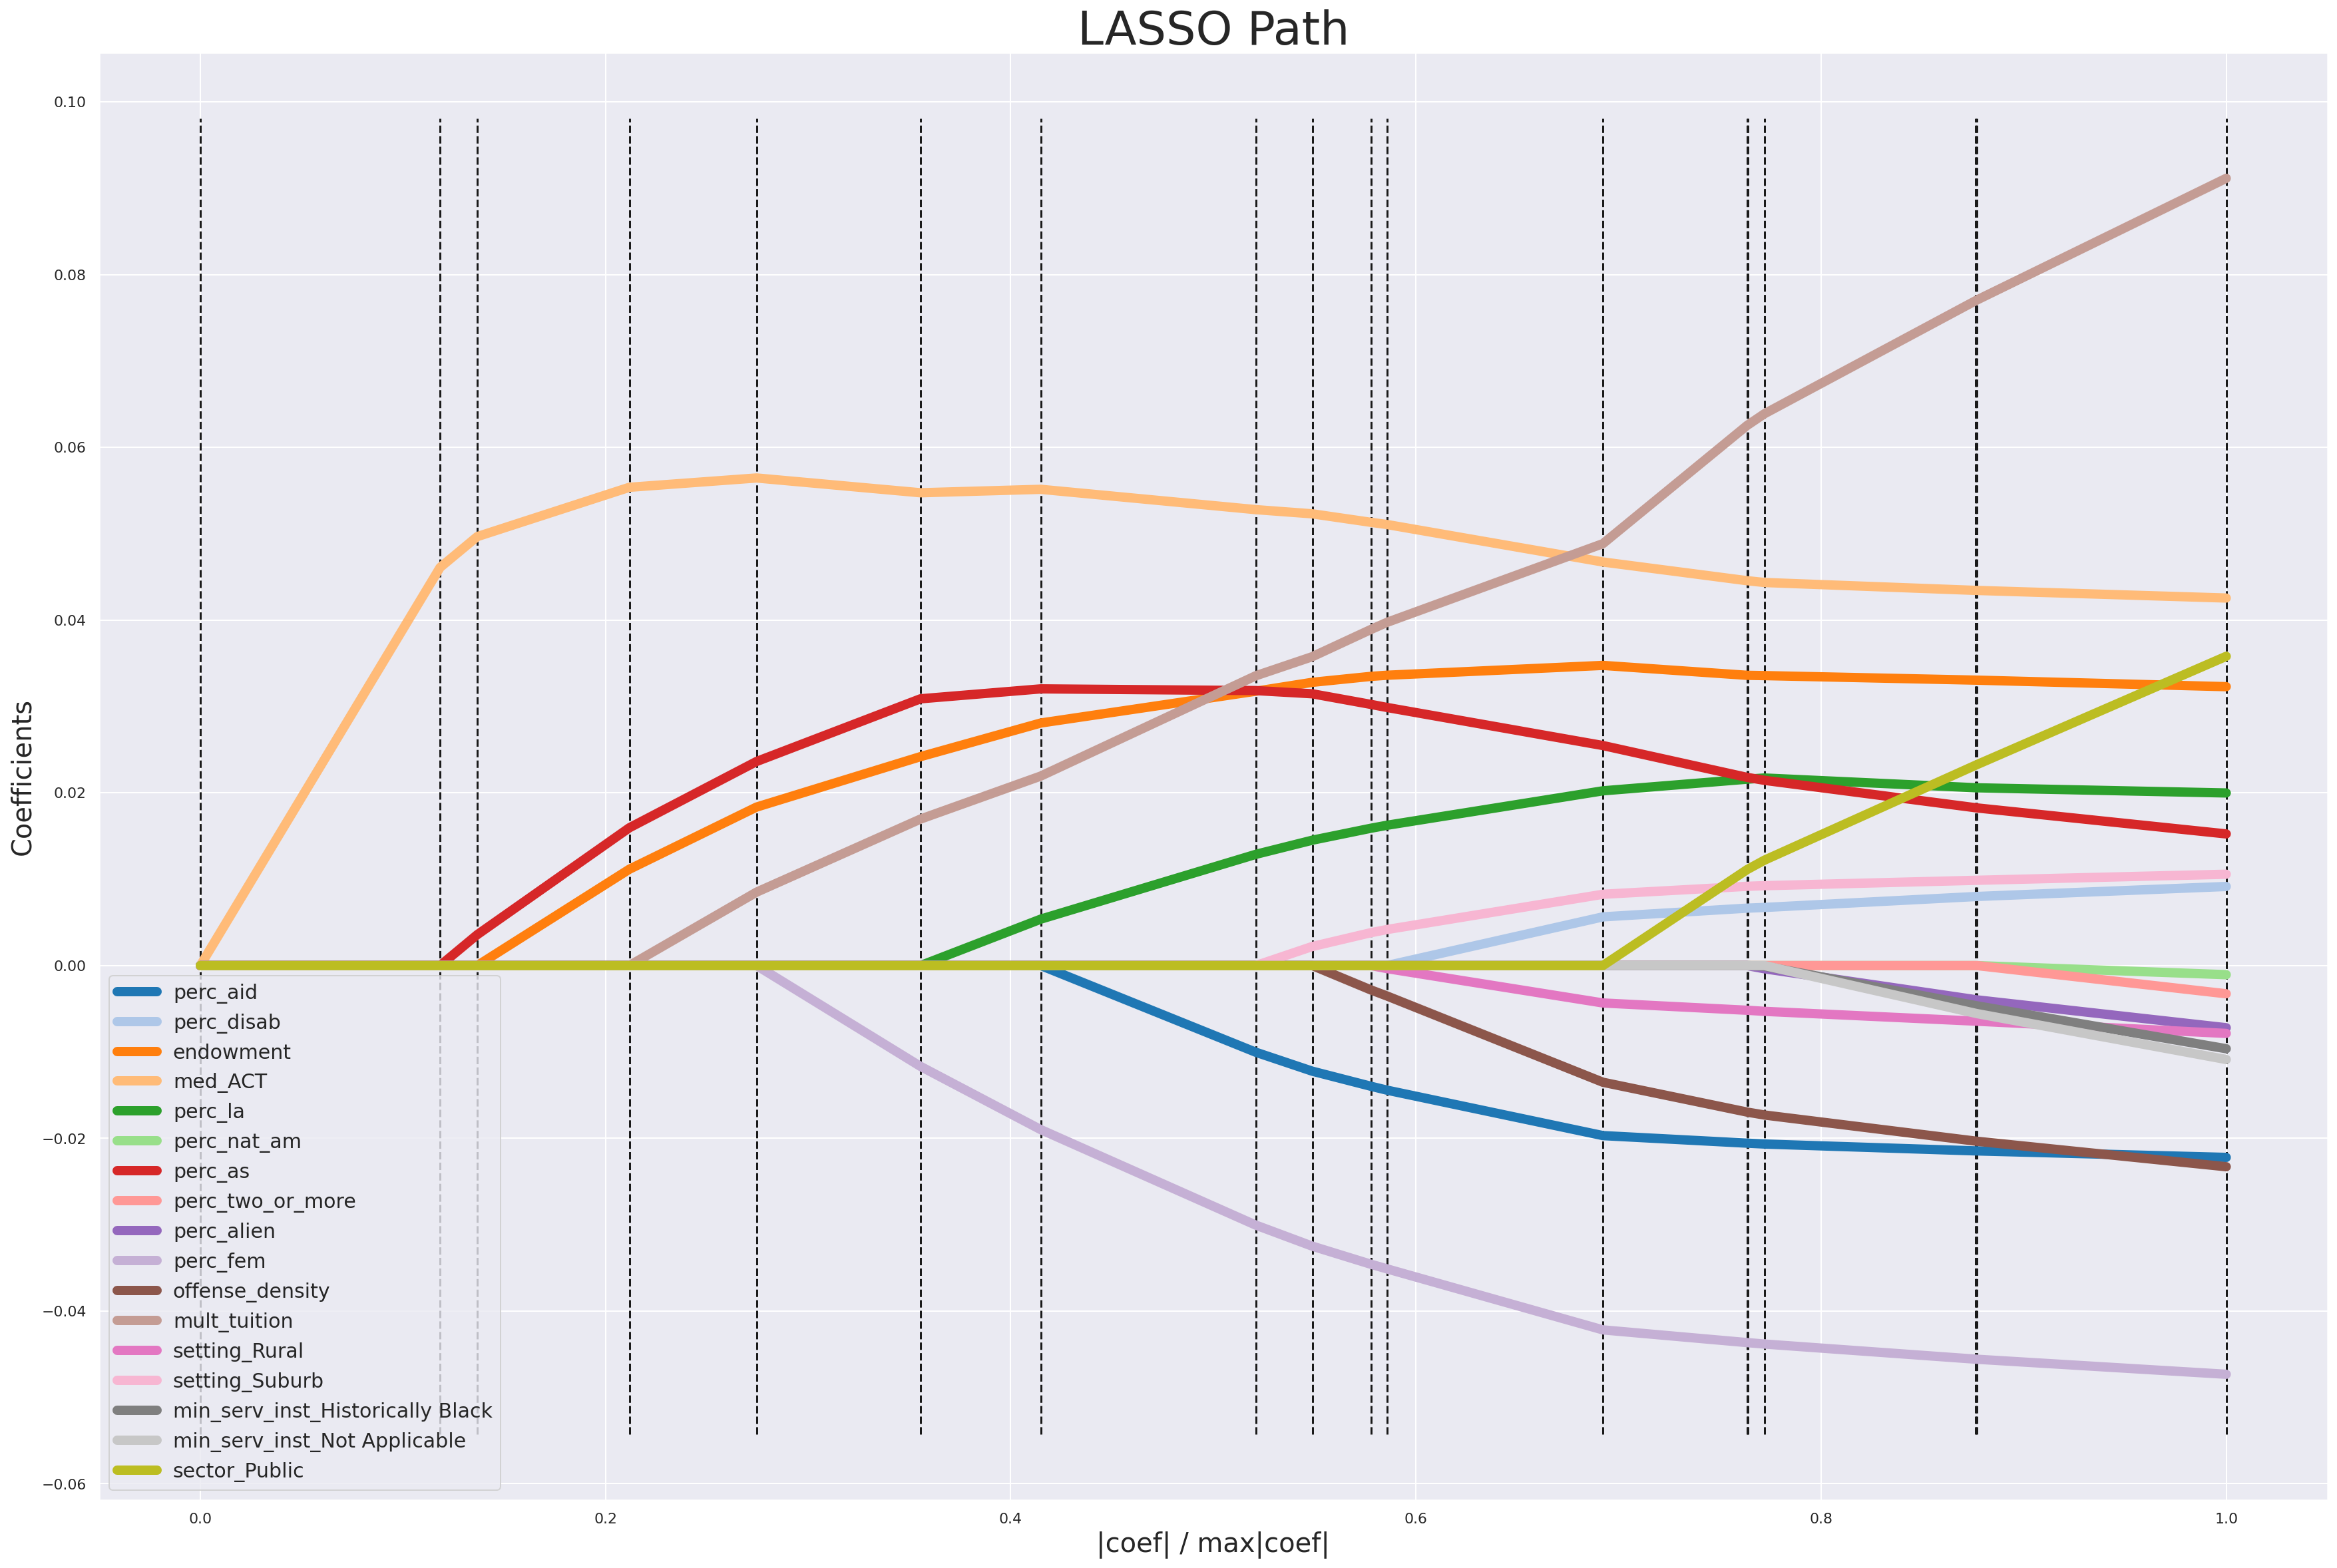

In [90]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)


plt.figure(figsize=(30,20))
plt.plot(xx, coefs.T, linestyle='-', linewidth=7)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|', fontsize=20)
plt.ylabel('Coefficients', fontsize=20)
plt.title('LASSO Path', fontsize=35)
plt.axis('tight')
plt.legend(X.columns, loc='best', prop={'size': 15})
plt.show()

In [34]:
#Texas A&M has large endowment, low tuition
#Income gaps by race
#perc_fem negatively correlated, further emphasizing the male-female income gap
#perc_aid negatively correlated, probably because the people that recieved aid came from lower income families to begin
#with, thus less social capital to work with in the future
#perc_la positively correlated!


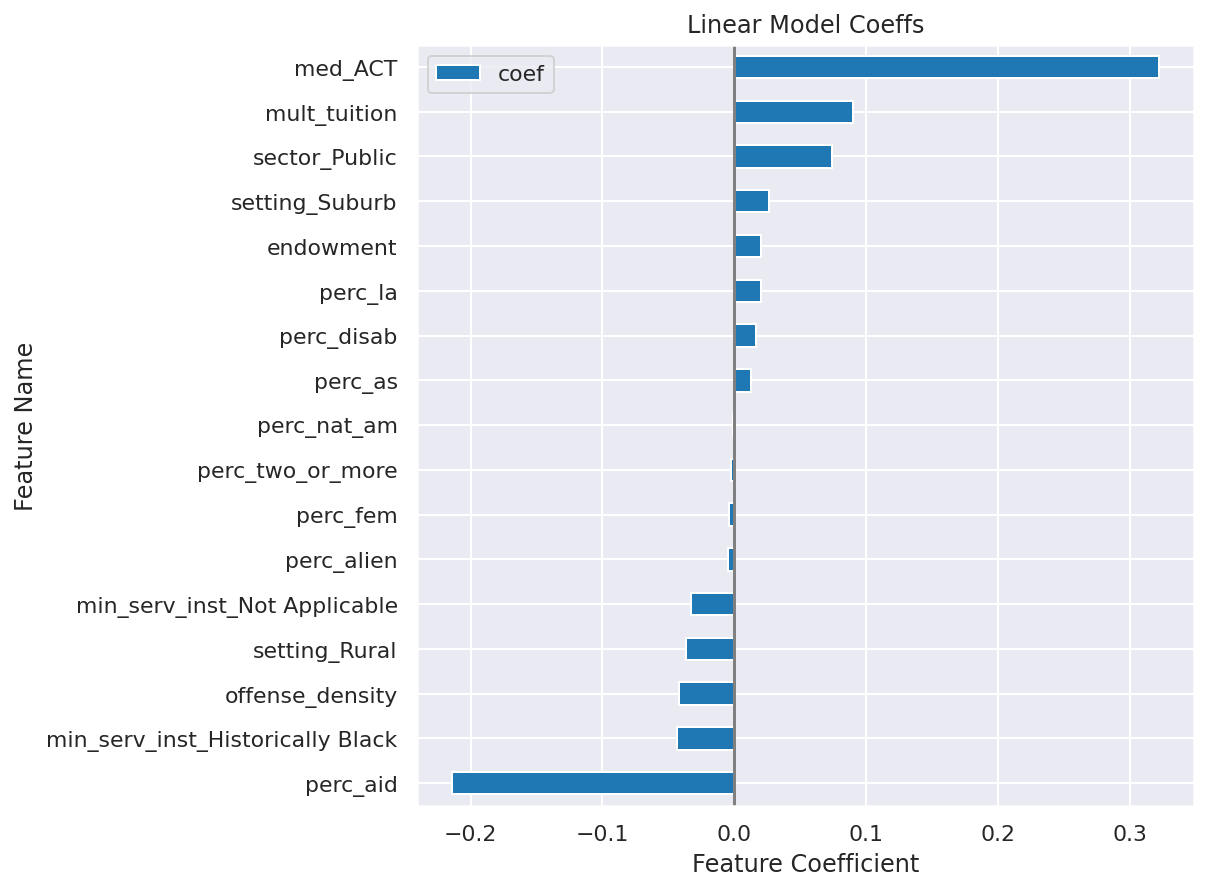

In [74]:
coefs = []
for coef, feature in sorted(zip(lr.coef_, X.columns)):
    coefs.append([feature, coef])
coefs = pd.DataFrame(coefs, columns= ['features', 'coef']).set_index('features')
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Model Coeffs')
plt.xlabel('Feature Coefficient')
plt.ylabel('Feature Name')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [36]:
logs

['student_fac_ratio',
 'perc_aid',
 'perc_disab',
 'endowment',
 'med_ACT',
 'perc_admit',
 'med_income_after_10',
 'perc_la',
 'perc_nat_am',
 'perc_as',
 'perc_two_or_more',
 'perc_alien',
 'perc_over_25',
 'offense_density',
 'mult_tuition']

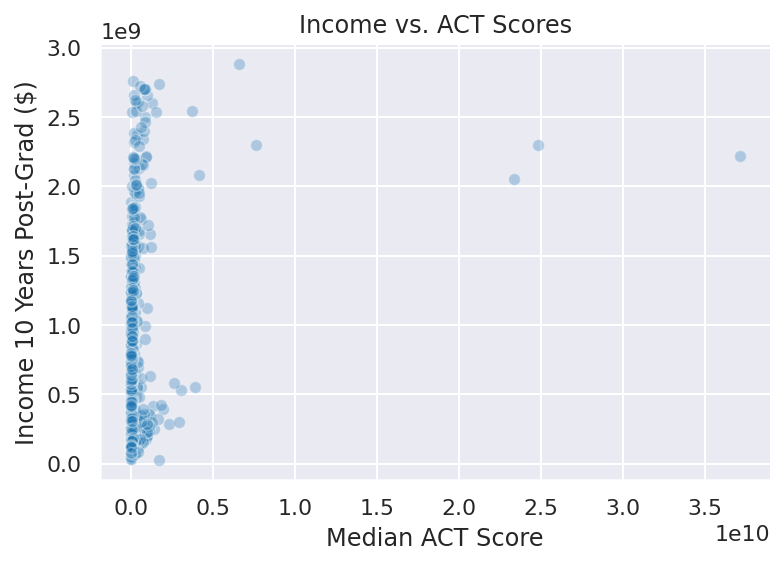

In [95]:
sns.scatterplot(x = np.exp(df.endowment) - .01, y=np.exp(df.mult_tuition) - .01, alpha=.3)
plt.xlabel('Median ACT Score')
plt.ylabel('Income 10 Years Post-Grad ($)')
plt.title('Income vs. ACT Scores')
sns.despine()

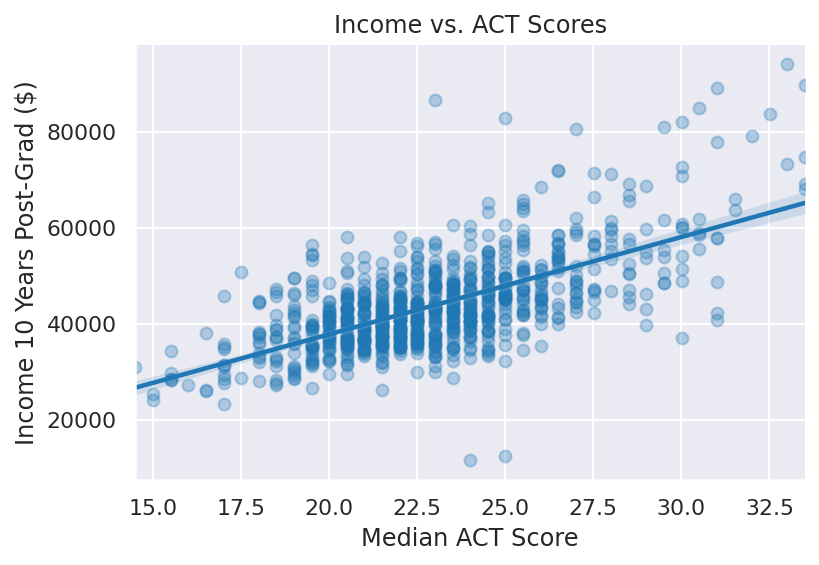

In [73]:
sns.regplot(x = np.exp(df.med_ACT), y=np.exp(df.med_income_after_10) - .01, scatter_kws={'alpha':0.3})
plt.xlabel('Median ACT Score')
plt.ylabel('Income 10 Years Post-Grad ($)')
plt.title('Income vs. ACT Scores')
sns.despine()

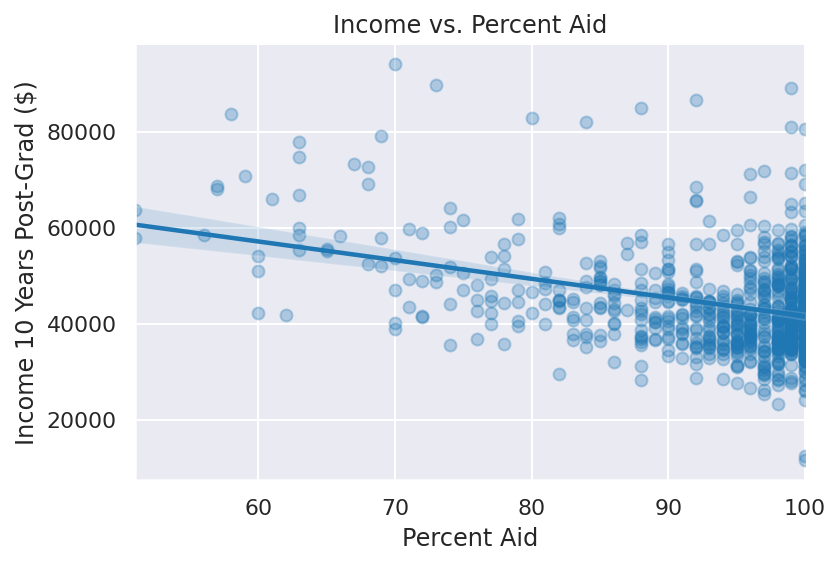

In [71]:
sns.regplot(x = np.exp(df.perc_aid), y=np.exp(df.med_income_after_10) - .01, scatter_kws={'alpha':0.3})
plt.xlabel('Percent Aid')
plt.ylabel('Income 10 Years Post-Grad ($)')
plt.title('Income vs. Percent Aid')
sns.despine()

In [62]:
for coef, feature in sorted(zip(lr.coef_, X.columns)):
    print([coef, feature])

[-0.21407597560429, 'perc_aid']
[-0.04331508217766324, 'min_serv_inst_Historically Black']
[-0.042144684021446346, 'offense_density']
[-0.03671220296576802, 'setting_Rural']
[-0.032522808386355365, 'min_serv_inst_Not Applicable']
[-0.0051103424050467, 'perc_alien']
[-0.00396018400107008, 'perc_fem']
[-0.0024148757969692167, 'perc_two_or_more']
[-0.0008768114709103965, 'perc_nat_am']
[0.012824796008047836, 'perc_as']
[0.016244049952939862, 'perc_disab']
[0.020049520835871693, 'perc_la']
[0.020135415320286384, 'endowment']
[0.026088545480181875, 'setting_Suburb']
[0.07399077293325992, 'sector_Public']
[0.08990095777837792, 'mult_tuition']
[0.32189017614797105, 'med_ACT']
